<a href="https://colab.research.google.com/github/andysontran/13-CHL5230-F23/blob/main/stroke_pred_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CHL5230H (F23): Datathon 2 - Early Prediction of Heart Failure
# Team Members:
#   No_13:  Katherine Lu  Amanda Rahmadian  Son Tran

# Dataset Used:
#   Cardiovascular Event Dataset (dataset.csv)
#     Attribute	Description:
#       id	Unique identifier
#       gender	“Male”, “Female” or “Other”
#       age	Age of the patient
#       hypertension	0 if the patient doesn’t have hypertension, 1 if they do
#       heart_disease	0 if the patient doesn’t have any heart diseases, 1 if they do
#       ever_married	“No” or “Yes”
#       work_type	“Children”, “Govt_jov”, “Never_worked”, “Private” or “Self-employed”
#       Residence_type	“Rural” or “Urban”
#       avg_glucose_level	Average glucose level in blood
#       bmi	Body mass index
#       smoking_status	“Formerly smoked”, “Never smoked”, “Smokes” or “Unknown”*
#       stroke	1 if the patient had a stroke, 0 if not

# 1 File Input

In [169]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Clone files on Github repository to Drive
!git clone https://github.com/andysontran/13-CHL5230-F23.git

# Set working directory
%cd 13-CHL5230-F23/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into '13-CHL5230-F23'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 49 (delta 23), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (49/49), 2.95 MiB | 8.81 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content/13-CHL5230-F23/13-CHL5230-F23


In [170]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

# Load the Cardiovascular Event Dataset into a Pandas df
import pandas as pd

data = pd.read_csv('Cardiovascular Event Dataset.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# 2 Data Pre-processing and Exploratory Data Analysis

In [171]:
# Remove the id row
data.drop('id', axis=1, inplace=True)
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


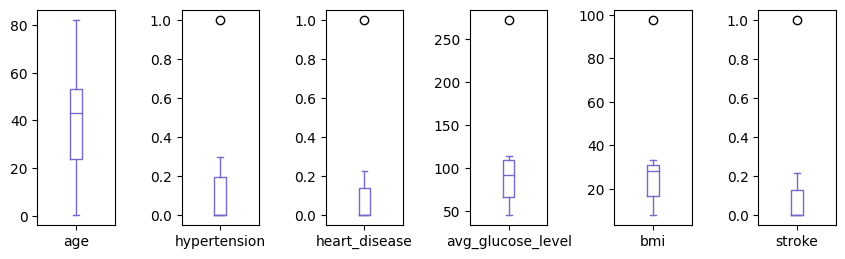

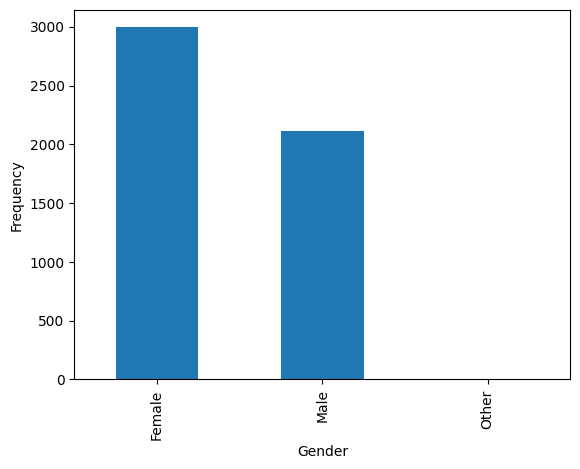

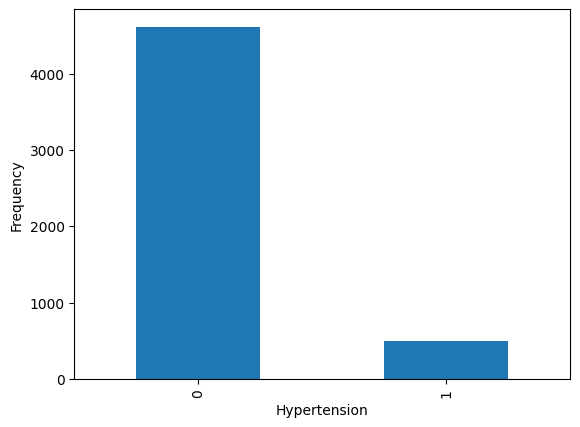

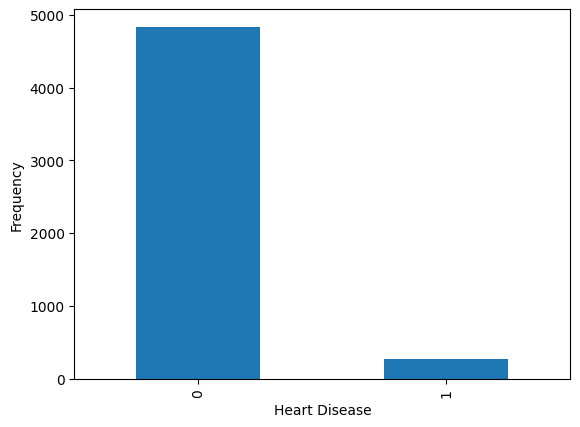

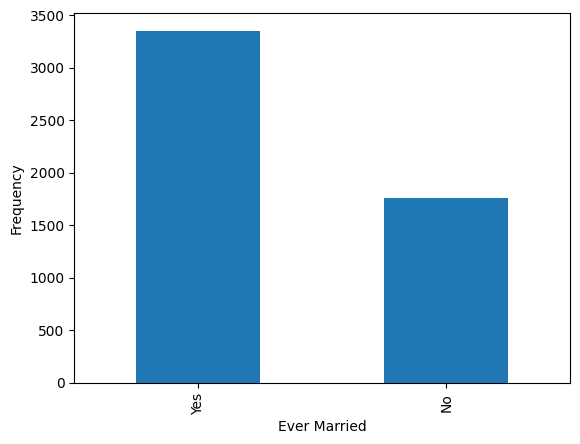

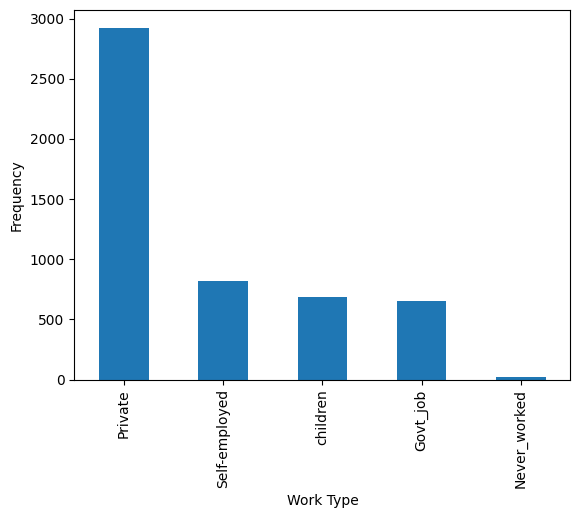

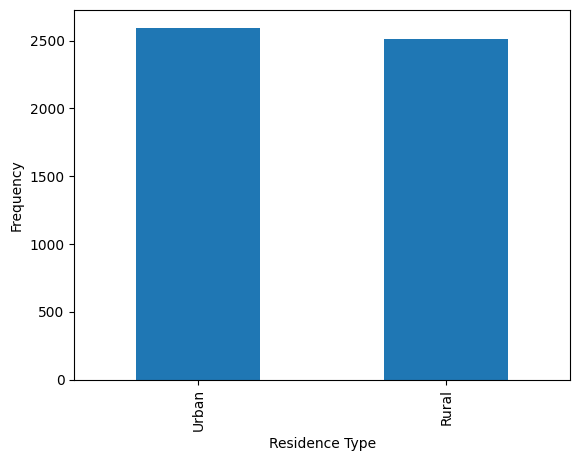

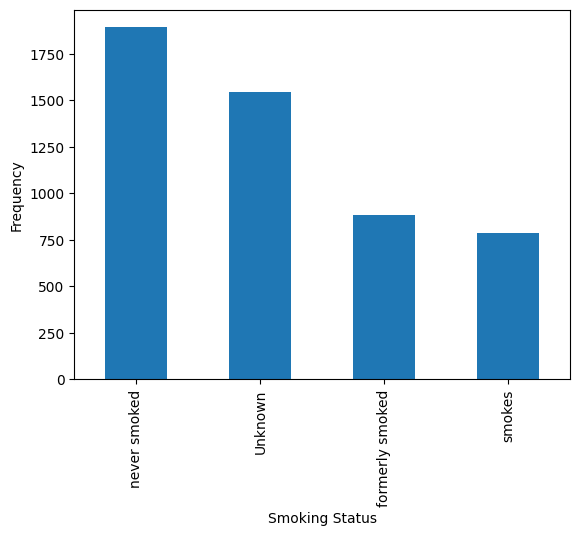

In [172]:
# Exploration of the dataset, dropping the 'count' row for better visualization
description = data.describe()
description
description = description.drop('count')

# Plot some graphs to visually show data distribution

# Box and whisker plots (only looking at continuous variables)
description.plot(kind='box', subplots=True, layout=(2, 7), figsize=(10, 5),
                 color='#7569c9')
plt.tight_layout()
plt.show()

# Bar graphs (for categorical variables)
data['gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()
data['hypertension'].value_counts().plot(kind='bar')
plt.xlabel('Hypertension')
plt.ylabel('Frequency')
plt.show()
data['heart_disease'].value_counts().plot(kind='bar')
plt.xlabel('Heart Disease')
plt.ylabel('Frequency')
plt.show()
data['ever_married'].value_counts().plot(kind='bar')
plt.xlabel('Ever Married')
plt.ylabel('Frequency')
plt.show()
data['work_type'].value_counts().plot(kind='bar')
plt.xlabel('Work Type')
plt.ylabel('Frequency')
plt.show()
data['Residence_type'].value_counts().plot(kind='bar')
plt.xlabel('Residence Type')
plt.ylabel('Frequency')
plt.show()
data['smoking_status'].value_counts().plot(kind='bar')
plt.xlabel('Smoking Status')
plt.ylabel('Frequency')
plt.show()

<Axes: >

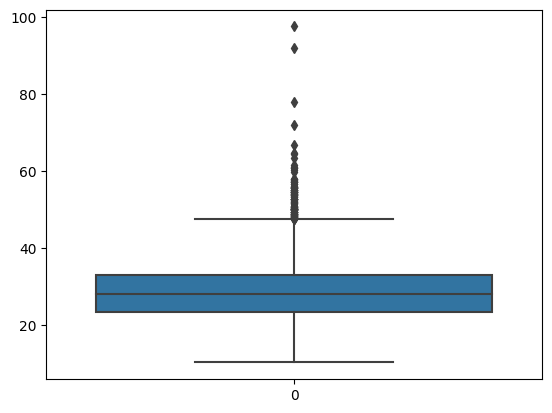

In [173]:
# Box plot of 'bmi'
sns.boxplot(data['bmi'])

<Axes: >

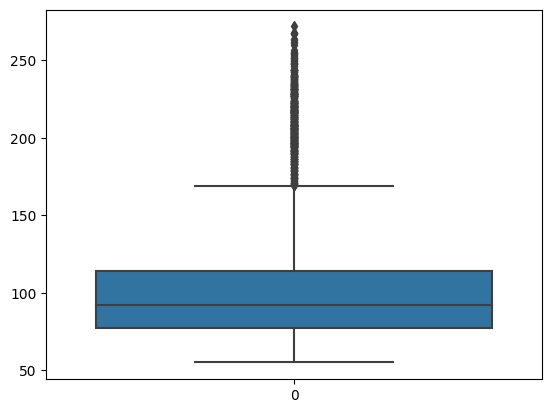

In [174]:
# Box plot of 'avg_glucose_level'
sns.boxplot(data['avg_glucose_level'])

In [175]:
# Since gender=Other only has 1 observation in the dataset, we decided to drop
# this row from our analysis
data.drop(3116,axis=0,inplace=True)

In [176]:
# Code the binary variables gender, ever_married, Residence_type into numerical values;
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})
data['ever_married'] = data['ever_married'].map({'No': 0, 'Yes': 1})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})

In [177]:
# Since children in the dataset skew age and BMI (and as BMI is not as accurate for youth), we decided to restrict our models to adults only, so remove work_type=children
data = data[data.work_type != 'children']

# and remove anyone under age 18
data = data[data.age >= 18]

In [178]:
# Create one-hot coding for work_type
data['work_type_Private'] = np.where(data['work_type']=='Private', 1, 0)
data['work_type_Selfemployed'] = np.where(data['work_type']=='Self-employed', 1, 0)
data['work_type_Govtjob'] = np.where(data['work_type']=='Govt_job', 1, 0)
data['work_type_Never'] = np.where(data['work_type']=='Never_worked', 1, 0)
data.drop ('work_type', axis=1, inplace=True)

In [179]:
# Create one-hot coding for smoking
data['smoking_status_Former'] = np.where(data['smoking_status']=='formerly smoked', 1, 0)
data['smoking_status_Never'] = np.where(data['smoking_status']=='never smoked', 1, 0)
data['smoking_status_Smokes'] = np.where(data['smoking_status']=='smokes', 1, 0)
data['smoking_status_Unknown'] = np.where(data['smoking_status']=='Unknown', 1, 0)
data.drop ('smoking_status', axis=1, inplace=True)

In [180]:
# Check for missing values in each column
print(data.isnull().sum())

gender                      0
age                         0
hypertension                0
heart_disease               0
ever_married                0
Residence_type              0
avg_glucose_level           0
bmi                       181
stroke                      0
work_type_Private           0
work_type_Selfemployed      0
work_type_Govtjob           0
work_type_Never             0
smoking_status_Former       0
smoking_status_Never        0
smoking_status_Smokes       0
smoking_status_Unknown      0
dtype: int64


In [181]:
# For BMI, replace zeros with nan to handle missing values
data[['bmi']] = data[['bmi']].replace(0, np.nan)

# Fill missing values with median
data.fillna(data.median(), inplace=True)

# Check to see if there are no more missing values
print(data.isnull().sum())

gender                    0
age                       0
hypertension              0
heart_disease             0
ever_married              0
Residence_type            0
avg_glucose_level         0
bmi                       0
stroke                    0
work_type_Private         0
work_type_Selfemployed    0
work_type_Govtjob         0
work_type_Never           0
smoking_status_Former     0
smoking_status_Never      0
smoking_status_Smokes     0
smoking_status_Unknown    0
dtype: int64


In [182]:
# Explore dataset again, after pre-processing of data
description = data.describe()
description

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Selfemployed,work_type_Govtjob,work_type_Never,smoking_status_Former,smoking_status_Never,smoking_status_Smokes,smoking_status_Unknown
count,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.00000,4253.000000
mean,0.605690,50.207853,0.116859,0.064660,0.788385,0.509993,108.506207,30.382177,0.058077,0.656008,0.189748,0.153068,0.001176,0.201975,0.411945,0.18340,0.202680
std,0.488759,17.827267,0.321290,0.245954,0.408502,0.499959,47.772032,7.083660,0.233916,0.475094,0.392148,0.360096,0.034271,0.401521,0.492243,0.38704,0.402044
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,55.120000,11.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,36.000000,0.000000,0.000000,1.000000,0.000000,77.480000,25.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.000000,51.000000,0.000000,0.000000,1.000000,1.000000,92.440000,29.200000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,1.000000,64.000000,0.000000,0.000000,1.000000,1.000000,116.120000,33.800000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


<Axes: >

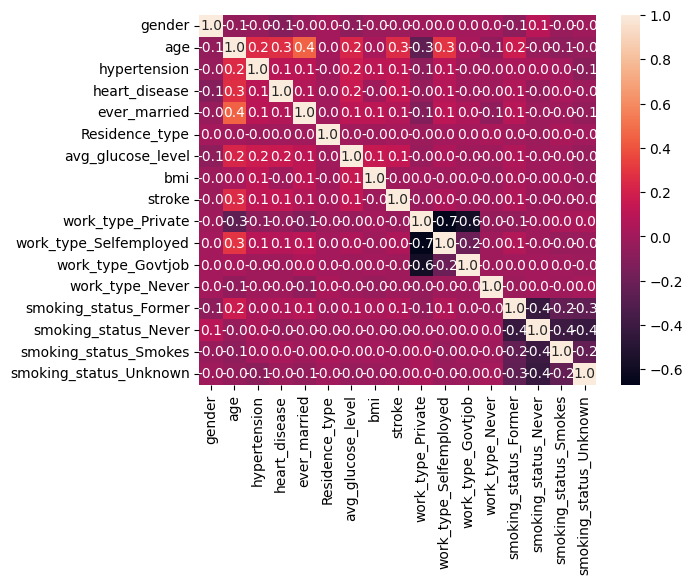

In [183]:
# Correlation matrix to quantify relationships (this might not be super helpful
# for us, since we have so many categorical variables. i think we should just
# fix for collinearity using L1 or L2
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
# For the continuous variables, they don't seem to be heavily correlated with
# each other

# 3.1 ML Analysis (Pre-processed Data)

**3.1.1 Implement K-NN**

In [195]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'none'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature: gender, Score: 0.02874
Feature: age, Score: 0.19216
Feature: hypertension, Score: 0.02844
Feature: heart_disease, Score: 0.02279
Feature: ever_married, Score: 0.00583
Feature: Residence_type, Score: 0.03142
Feature: avg_glucose_level, Score: 0.31739
Feature: bmi, Score: 0.24528
Feature: work_type_Private, Score: 0.02771
Feature: work_type_Selfemployed, Score: 0.01492
Feature: work_type_Govtjob, Score: 0.00604
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.01190
Feature: smoking_status_Never, Score: 0.02126
Feature: smoking_status_Smokes, Score: 0.01668
Feature: smoking_status_Unknown, Score: 0.02942


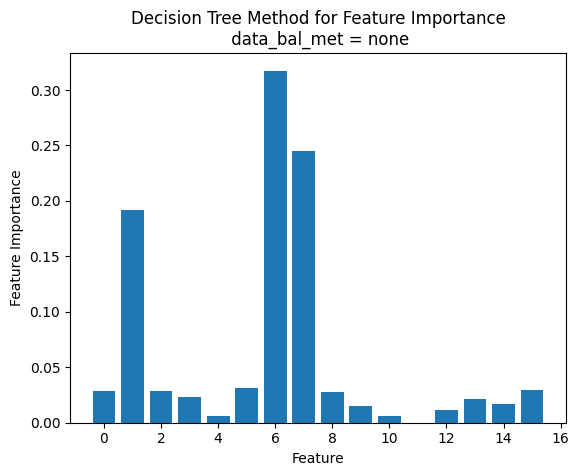

In [196]:
# Decision tree for feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier()
# Fit the model
model.fit(X_train, y_train)
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Decision Tree Method for Feature Importance\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

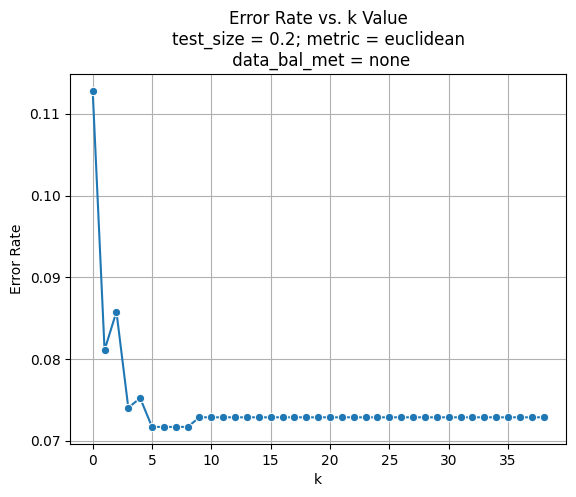

In [197]:
## CONSTANTS
# Test size used
size = 0.2
# Distance metric used
met = 'euclidean'
##

# Check error rate for k = 1 to 40
error_rate = []

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors = k, metric = met)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  error_rate.append(1 - accuracy_score(y_test, y_pred))

# Plot line graph of error rate
sns.lineplot(error_rate, marker = 'o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k Value\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met)
plt.show()

[[776  13]
 [ 60   2]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       789
           1       0.13      0.03      0.05        62

    accuracy                           0.91       851
   macro avg       0.53      0.51      0.50       851
weighted avg       0.87      0.91      0.89       851



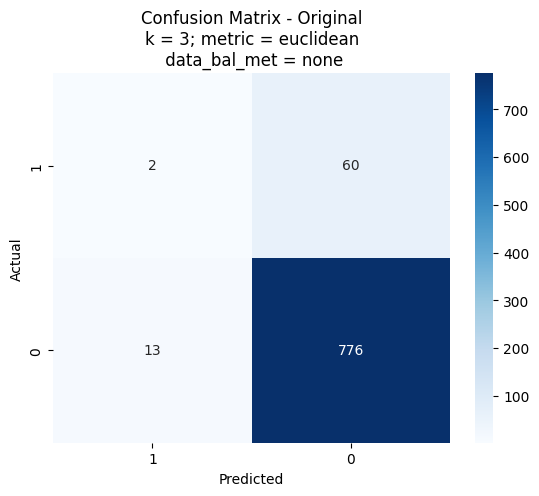

In [198]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# K value used
k = 3

# Initialize K-NN classifier and fit the model
knn = KNeighborsClassifier(n_neighbors = k, metric = met)
knn.fit(X_train, y_train)

# Predict using test data
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Original\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Feature: gender, Score: -0.00494
Feature: age, Score: -0.00047
Feature: hypertension, Score: -0.00329
Feature: heart_disease, Score: 0.00000
Feature: ever_married, Score: 0.00118
Feature: Residence_type, Score: -0.00376
Feature: avg_glucose_level, Score: 0.00024
Feature: bmi, Score: -0.00423
Feature: work_type_Private, Score: 0.00024
Feature: work_type_Selfemployed, Score: -0.00306
Feature: work_type_Govtjob, Score: 0.00165
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: -0.00259
Feature: smoking_status_Never, Score: -0.00071
Feature: smoking_status_Smokes, Score: -0.00235
Feature: smoking_status_Unknown, Score: -0.00235


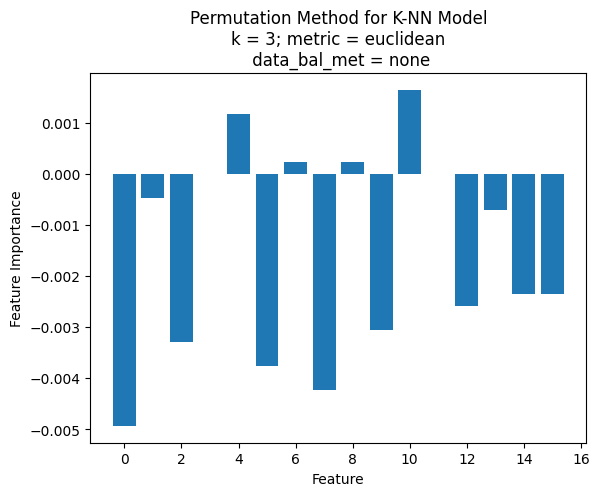

In [199]:
# Permutation for feature importance with K-NN for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Fit the model
results = permutation_importance(knn, X_test, y_test, scoring = 'accuracy')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for count,value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Permutation Method for K-NN Model\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

**3.1.2 Implement Logistic Regression**

In [200]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'none'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [201]:
## CONSTANTS
pen = 'l1'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv, class_weight='balanced')
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

# Display regression coefficients and R-squared value of model
print('The intercept is: %.5f' % log_reg.intercept_)
print('The regression coefficients are: ' + str(log_reg.coef_))
print('The R-squared value is: %.5f' % log_reg.score(X_train, y_train))

The intercept is: -5.00852
The regression coefficients are: [[-0.05657681  0.07563987  0.49133741  0.22781802 -0.28258571  0.11986121
   0.00342656  0.00986247  0.0636535  -0.01096138  0.          0.
   0.03922914 -0.34470472  0.         -0.08334321]]
The R-squared value is: 0.71634


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82       789
           1       0.19      0.84      0.30        62

    accuracy                           0.72       851
   macro avg       0.58      0.77      0.56       851
weighted avg       0.92      0.72      0.79       851


Confusion Matrix:
[[560 229]
 [ 10  52]] 



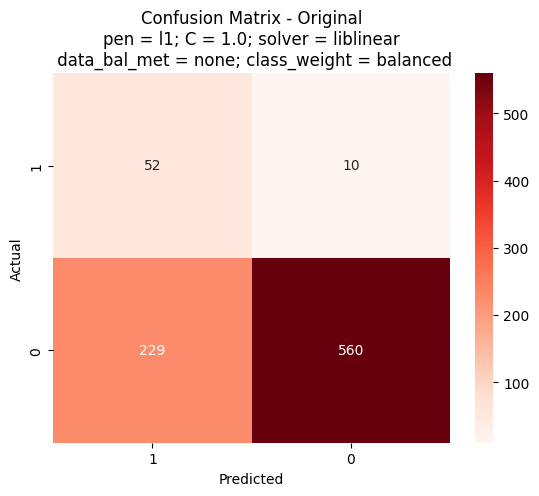

In [202]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Original\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met + '; class_weight = balanced'
plt.title(title)

plt.show()

In [203]:
## CONSTANTS
pen = 'l2'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model, with L2 instead
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv, class_weight='balanced')
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

# Display regression coefficients and R-squared value of model
print('The intercept is: %.5f' % log_reg.intercept_)
print('The regression coefficients are: ' + str(log_reg.coef_))
print('The R-squared value is: %.5f' % log_reg.score(X_train, y_train))

The intercept is: -3.12603
The regression coefficients are: [[-0.07178741  0.07431129  0.50182266  0.24620572 -0.30930122  0.1187168
   0.00340507  0.00689097 -0.92844512 -1.0000417  -0.99724542 -0.20029949
  -0.63260383 -1.02916832 -0.68831996 -0.77593961]]
The R-squared value is: 0.71429


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       789
           1       0.19      0.84      0.30        62

    accuracy                           0.72       851
   macro avg       0.58      0.78      0.57       851
weighted avg       0.92      0.72      0.79       851


Confusion Matrix:
[[562 227]
 [ 10  52]] 



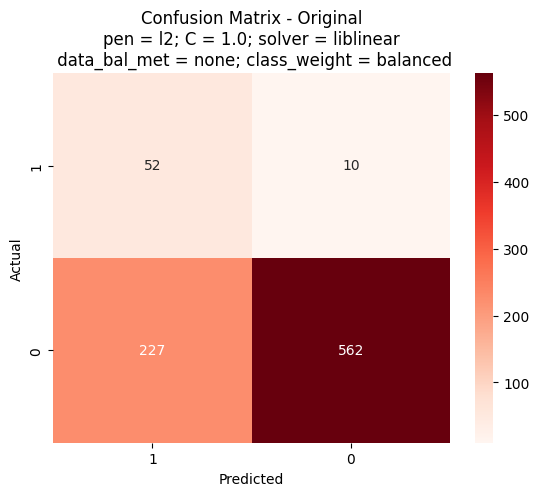

In [204]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Original\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met + '; class_weight = balanced'
plt.title(title)

plt.show()

In [205]:
### model summary

import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = data.drop('stroke', axis=1)
y = data['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.182526
         Iterations 26
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 4253
Model:                          Logit   Df Residuals:                     4238
Method:                           MLE   Df Model:                           14
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.1765
Time:                        20:54:00   Log-Likelihood:                -776.28
converged:                       True   LL-Null:                       -942.64
Covariance Type:            nonrobust   LLR p-value:                 1.720e-62
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -10.4622        nan        nan        nan         nan     

# 3.2 ML Analysis (Data Balancing by Random Upsampling)

**3.2.1 Split Pre-processed Data into Training/Testing, then Data Balance by Random Upsampling on Training Dataset**



1.   Perform 80/20 split of original, pre-processed dataset to generate training and testing subsets
2.   Balance 'stroke' occurrences by Random Upsampling on training subset
3.   Perform a further 80/20 split on the balanced, training subset to generate training and testing subsets to use in ML models. Use accordingly to train and test performance within balanced data
4.   Evaluate trained ML models on original, pre-processed testing subset (unbalanced) that is unseen by the models thus far -- generated in Step 1



In [206]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data['stroke']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

In [207]:
Xy_train = pd.concat([X_train, y_train], axis=1, join="inner")

In [208]:
data_0 = Xy_train[Xy_train['stroke'] == 0]
data_1 = Xy_train[Xy_train['stroke'] == 1]

Xy_train['stroke'].value_counts()

0    3217
1     185
Name: stroke, dtype: int64

In [209]:
# Import necessary library
from sklearn.utils import resample

data_1 = resample(data_1, replace = True, n_samples = data_0.shape[0],
                  random_state = 1)

In [210]:
print(data_1.shape)
print(data_0.shape)

data_1['stroke'].value_counts()
data_0['stroke'].value_counts()

(3217, 17)
(3217, 17)


0    3217
Name: stroke, dtype: int64

In [211]:
# Concatenate upsampled data
data_up = np.concatenate((data_0, data_1))

# Create the balanced df
data_up = pd.DataFrame(data_up)
data_up.columns = list(data_0.columns)

In [212]:
print(data_up.shape)

data_up['stroke'].value_counts()

(6434, 17)


0.0    3217
1.0    3217
Name: stroke, dtype: int64

**3.2.2 Implement K-NN**

In [213]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_up[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_up['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'Rand_upsampling'
##

# Split data into training and testing sets
X_up_train, X_up_test, y_up_train, y_up_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Scale features
scaler = StandardScaler()
X_up_train = scaler.fit_transform(X_up_train)
X_up_test = scaler.transform(X_up_test)

Feature: gender, Score: 0.01313
Feature: age, Score: 0.38678
Feature: hypertension, Score: 0.03027
Feature: heart_disease, Score: 0.00808
Feature: ever_married, Score: 0.01413
Feature: Residence_type, Score: 0.01641
Feature: avg_glucose_level, Score: 0.22913
Feature: bmi, Score: 0.19911
Feature: work_type_Private, Score: 0.01189
Feature: work_type_Selfemployed, Score: 0.01157
Feature: work_type_Govtjob, Score: 0.01318
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.01741
Feature: smoking_status_Never, Score: 0.01394
Feature: smoking_status_Smokes, Score: 0.02026
Feature: smoking_status_Unknown, Score: 0.01470


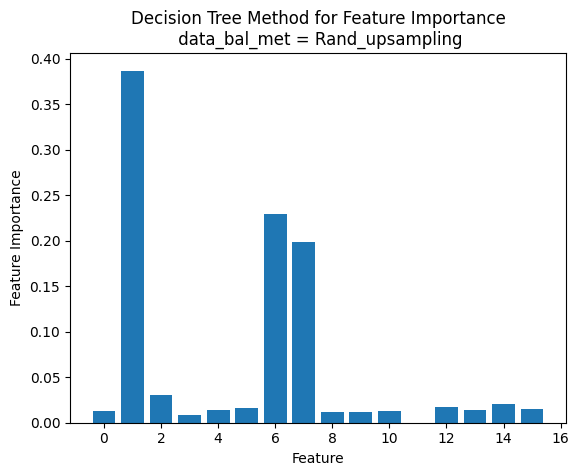

In [214]:
# Decision tree for feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier()
# Fit the model
model.fit(X_up_train, y_up_train)
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Decision Tree Method for Feature Importance\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

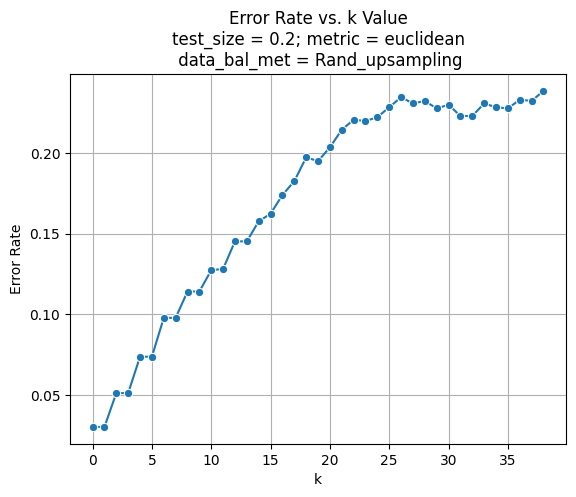

In [215]:
## CONSTANTS
# Test size used
size = 0.2
# Distance metric used
met = 'euclidean'
##

# Check error rate for k = 1 to 40
error_rate = []

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors = k, metric = met)
  knn.fit(X_up_train, y_up_train)
  y_up_pred = knn.predict(X_up_test)
  error_rate.append(1 - accuracy_score(y_up_test, y_up_pred))

# Plot line graph of error rate
sns.lineplot(error_rate, marker = 'o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k Value\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met)
plt.show()

[[593  66]
 [  0 628]]
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95       659
         1.0       0.90      1.00      0.95       628

    accuracy                           0.95      1287
   macro avg       0.95      0.95      0.95      1287
weighted avg       0.95      0.95      0.95      1287



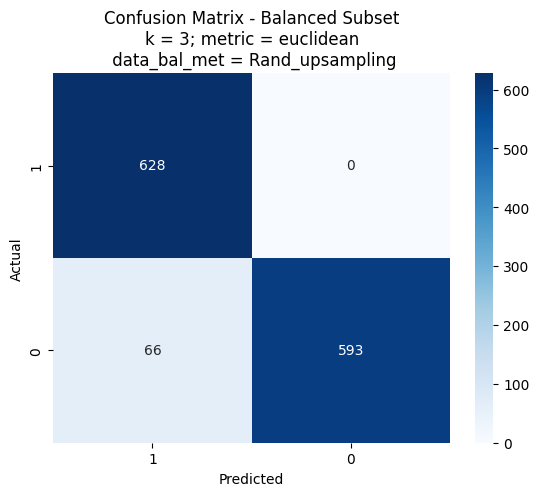

In [216]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# K value used
k = 3

# Initialize K-NN classifier and fit the model
knn = KNeighborsClassifier(n_neighbors = k, metric = met)
knn.fit(X_up_train, y_up_train)

# Predict using test data
y_up_pred = knn.predict(X_up_test)

# Evaluate the model
print(confusion_matrix(y_up_test, y_up_pred))
print(classification_report(y_up_test, y_up_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_up_test, y_up_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Balanced Subset\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Feature: gender, Score: 0.14141
Feature: age, Score: 0.20093
Feature: hypertension, Score: 0.10847
Feature: heart_disease, Score: 0.10319
Feature: ever_married, Score: 0.07925
Feature: Residence_type, Score: 0.14685
Feature: avg_glucose_level, Score: 0.15354
Feature: bmi, Score: 0.15524
Feature: work_type_Private, Score: -0.00000
Feature: work_type_Selfemployed, Score: 0.09169
Feature: work_type_Govtjob, Score: 0.06900
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.06822
Feature: smoking_status_Never, Score: -0.00031
Feature: smoking_status_Smokes, Score: 0.09604
Feature: smoking_status_Unknown, Score: 0.06030


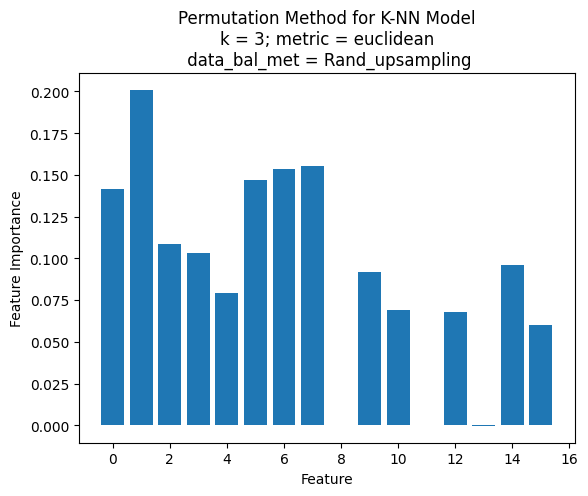

In [217]:
# Permutation for feature importance with K-NN for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Fit the model
results = permutation_importance(knn, X_up_test, y_up_test, scoring = 'accuracy')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for count,value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Permutation Method for K-NN Model\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

[[699  90]
 [ 47  15]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       789
           1       0.14      0.24      0.18        62

    accuracy                           0.84       851
   macro avg       0.54      0.56      0.55       851
weighted avg       0.88      0.84      0.86       851



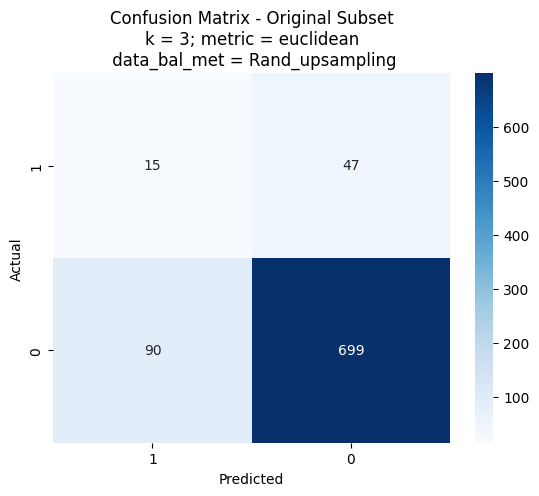

In [218]:
# Evaluate on original data
X_test = scaler.transform(X_test)
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Original Subset\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

**3.3.3 Implement Logistic Regression**

In [219]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Use previous data split for K-NN

## CONSTANTS
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'Upsampling'
##

In [220]:
## CONSTANTS
pen = 'l1'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_up_train, y_up_train)

# Display regression coefficients and R-squared value of model
print('The intercept is: %.5f' % log_reg.intercept_)
print('The regression coefficients are: ' + str(log_reg.coef_))
print('The R-squared value is: %.5f' % log_reg.score(X_up_train, y_up_train))

The intercept is: -0.05978
The regression coefficients are: [[ 0.          1.36195692  0.22837943  0.08456099 -0.0761768   0.05490877
   0.127002    0.04379151  0.02970765 -0.05370815  0.         -0.04731104
   0.10016255 -0.09012636  0.05284763  0.        ]]
The R-squared value is: 0.73888


Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75       659
         1.0       0.73      0.77      0.75       628

    accuracy                           0.75      1287
   macro avg       0.75      0.75      0.75      1287
weighted avg       0.75      0.75      0.75      1287


Confusion Matrix:
[[485 174]
 [146 482]] 



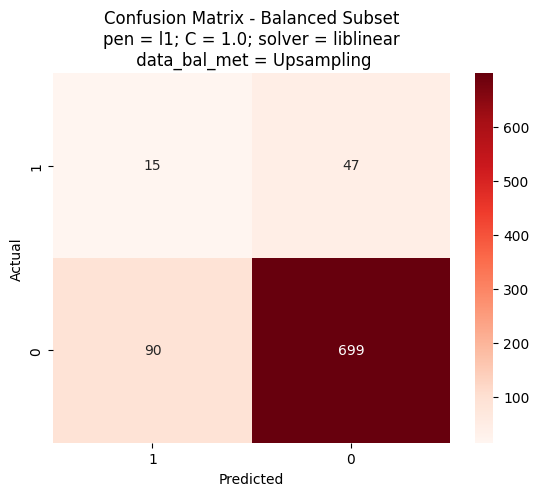

In [221]:
# Use the model to make predictions on the testing data
y_up_pred = log_reg.predict(X_up_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_up_test, y_up_pred)
class_report = classification_report(y_up_test, y_up_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced Subset\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       789
           1       0.19      0.84      0.31        62

    accuracy                           0.73       851
   macro avg       0.59      0.78      0.57       851
weighted avg       0.92      0.73      0.79       851


Confusion Matrix:
[[567 222]
 [ 10  52]] 



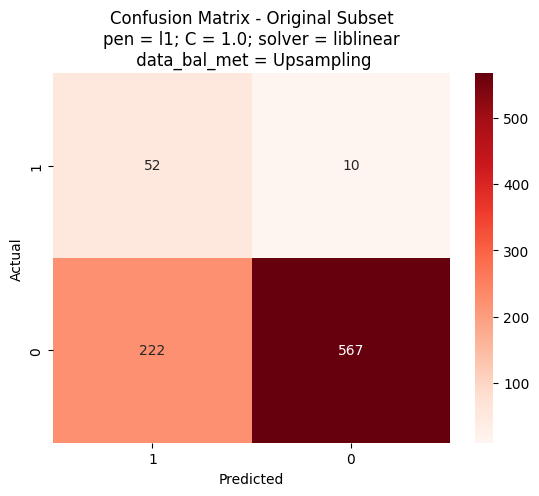

In [222]:
# Use the model to make predictions on the original testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Original Subset\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [223]:
## CONSTANTS
pen = 'l2'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model, with L2 instead
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_up_train, y_up_train)

# Display regression coefficients and R-squared value of model
print('The intercept is: %.5f' % log_reg.intercept_)
print('The regression coefficients are: ' + str(log_reg.coef_))
print('The R-squared value is: %.5f' % log_reg.score(X_up_train, y_up_train))

The intercept is: -0.06196
The regression coefficients are: [[ 1.10812782e-03  1.36184231e+00  2.29201468e-01  8.55404989e-02
  -7.75916035e-02  5.59252877e-02  1.27831107e-01  4.45036818e-02
   4.00828863e-02 -4.56417187e-02  7.13456409e-03 -9.54579718e-02
   8.87666201e-02 -1.04355637e-01  4.33376185e-02 -1.15058541e-02]]
The R-squared value is: 0.73927


Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75       659
         1.0       0.73      0.77      0.75       628

    accuracy                           0.75      1287
   macro avg       0.75      0.75      0.75      1287
weighted avg       0.75      0.75      0.75      1287


Confusion Matrix:
[[485 174]
 [146 482]] 



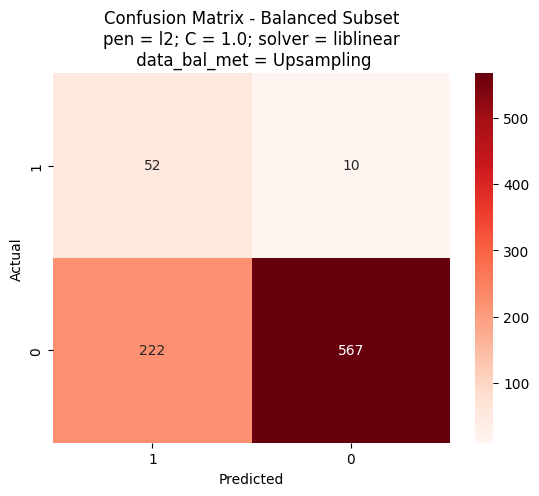

In [224]:
# Use the model to make predictions on the testing data
y_up_pred = log_reg.predict(X_up_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_up_test, y_up_pred)
class_report = classification_report(y_up_test, y_up_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced Subset\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       789
           1       0.19      0.84      0.31        62

    accuracy                           0.73       851
   macro avg       0.59      0.78      0.57       851
weighted avg       0.92      0.73      0.79       851


Confusion Matrix:
[[567 222]
 [ 10  52]] 



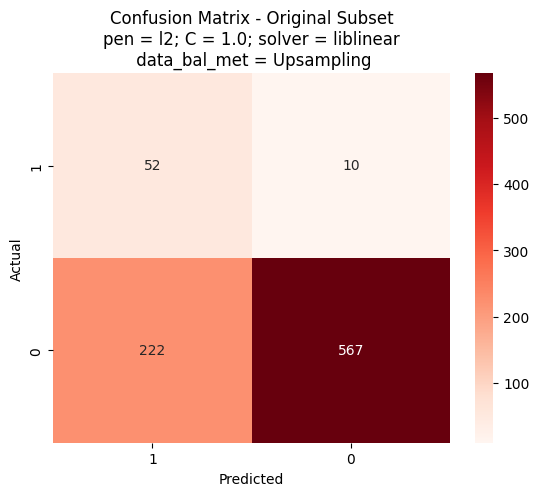

In [225]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Original Subset\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [226]:
### model summary

import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = data_up.drop('stroke', axis=1)
y = data_up['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

         Current function value: 0.515767
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 6434
Model:                          Logit   Df Residuals:                     6419
Method:                           MLE   Df Model:                           14
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.2559
Time:                        20:54:23   Log-Likelihood:                -3318.4
converged:                      False   LL-Null:                       -4459.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6.1040    1.2e+06  -5.08e-06      1.000   -2.36e+06    2.36e+06
gender                     0.

# 3.3 ML Analysis (Data Balancing by SMOTE)

1.   Perform 80/20 split of original, pre-processed dataset to generate training and testing subsets
2.   Balance 'stroke' occurrences by SMOTE on training subset
3.   Perform a further 80/20 split on the balanced, training subset to generate training and testing subsets to use in ML models. Use accordingly to train and test performance within balanced data
4.   Evaluate trained ML models on original, pre-processed testing subset (unbalanced) that is unseen by the models thus far -- generated in Step 1

**3.3.1 Split Pre-processed Data into Training/Testing, then Data Balance on Training Dataset by SMOTE (Synthetic Minority Oversampling Technique)**

In [227]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data['stroke']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

In [228]:
Xy_train = pd.concat([X_train, y_train], axis=1, join="inner")

oversample = SMOTE()

eval_data = Xy_train[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown','stroke']].sample(int(Xy_train.shape[0]*0.2),
                                                       random_state = 42)
train_data = data.drop(index = eval_data.index)

X_eval, y_eval = eval_data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']], eval_data['stroke']
X, y = train_data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']], train_data['stroke']

X, y = oversample.fit_resample(X,y)
data_ups = X.assign(stroke = y)

In [229]:
data_ups['stroke'].value_counts()

1    3366
0    3366
Name: stroke, dtype: int64

**3.3.2 Implement K-NN**

In [230]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_ups[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_ups['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'SMOTE'
##

# Split data into training and testing sets
X_ups_train, X_ups_test, y_ups_train, y_ups_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Scale features
scaler = StandardScaler()
X_ups_train = scaler.fit_transform(X_ups_train)
X_ups_test = scaler.transform(X_ups_test)

Feature: gender, Score: 0.02467
Feature: age, Score: 0.39061
Feature: hypertension, Score: 0.00669
Feature: heart_disease, Score: 0.00680
Feature: ever_married, Score: 0.02108
Feature: Residence_type, Score: 0.01355
Feature: avg_glucose_level, Score: 0.11101
Feature: bmi, Score: 0.07384
Feature: work_type_Private, Score: 0.07352
Feature: work_type_Selfemployed, Score: 0.04942
Feature: work_type_Govtjob, Score: 0.04302
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.04194
Feature: smoking_status_Never, Score: 0.06652
Feature: smoking_status_Smokes, Score: 0.04218
Feature: smoking_status_Unknown, Score: 0.03516


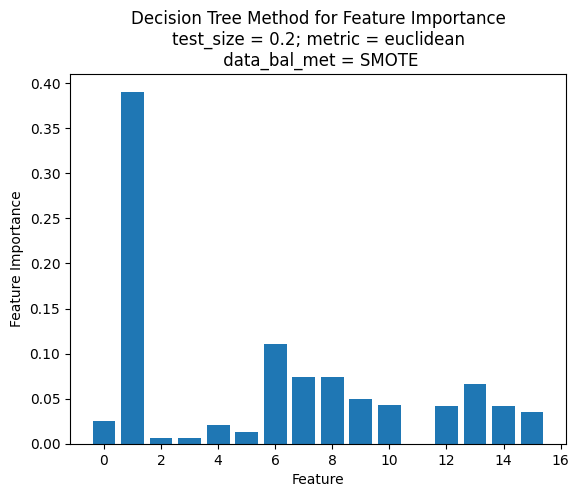

In [231]:
# Decision tree for feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier()
# Fit the model
model.fit(X_ups_train, y_ups_train)
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Decision Tree Method for Feature Importance\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

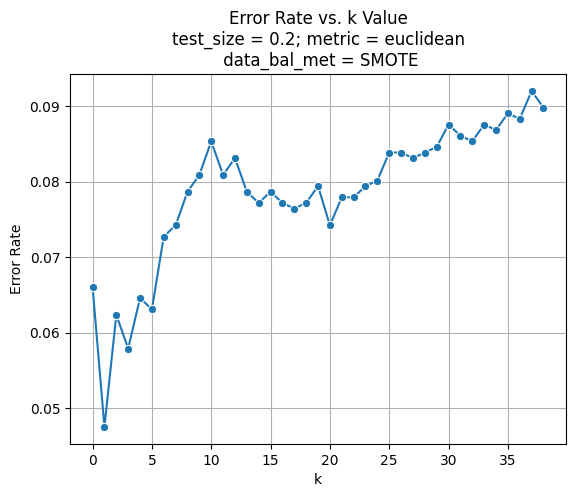

In [232]:
## CONSTANTS
# Test size used
size = 0.2
# Distance metric used
met = 'euclidean'
##

# Check error rate for k = 1 to 40
error_rate = []

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors = k, metric = met)
  knn.fit(X_ups_train, y_ups_train)
  y_ups_pred = knn.predict(X_ups_test)
  error_rate.append(1 - accuracy_score(y_ups_test, y_ups_pred))

# Plot line graph of error rate
sns.lineplot(error_rate, marker = 'o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k Value\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met)
plt.show()

[[635  48]
 [ 36 628]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       683
           1       0.93      0.95      0.94       664

    accuracy                           0.94      1347
   macro avg       0.94      0.94      0.94      1347
weighted avg       0.94      0.94      0.94      1347



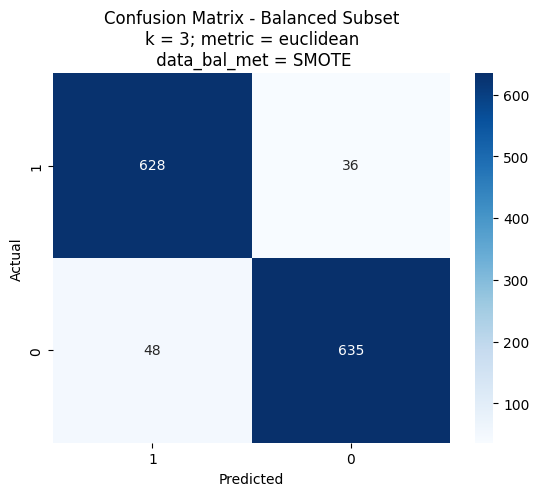

In [233]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# K value used
k = 3

# Initialize K-NN classifier and fit the model
knn = KNeighborsClassifier(n_neighbors = k, metric = met)
knn.fit(X_ups_train, y_ups_train)

# Predict using test data
y_ups_pred = knn.predict(X_ups_test)

# Evaluate the model
print(confusion_matrix(y_ups_test, y_ups_pred))
print(classification_report(y_ups_test, y_ups_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_ups_test, y_ups_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Balanced Subset\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Feature: gender, Score: 0.01648
Feature: age, Score: 0.05301
Feature: hypertension, Score: 0.01262
Feature: heart_disease, Score: 0.01648
Feature: ever_married, Score: 0.01559
Feature: Residence_type, Score: 0.02153
Feature: avg_glucose_level, Score: 0.02361
Feature: bmi, Score: 0.01589
Feature: work_type_Private, Score: 0.09428
Feature: work_type_Selfemployed, Score: 0.05390
Feature: work_type_Govtjob, Score: 0.05241
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.06622
Feature: smoking_status_Never, Score: 0.13719
Feature: smoking_status_Smokes, Score: 0.08775
Feature: smoking_status_Unknown, Score: 0.06548


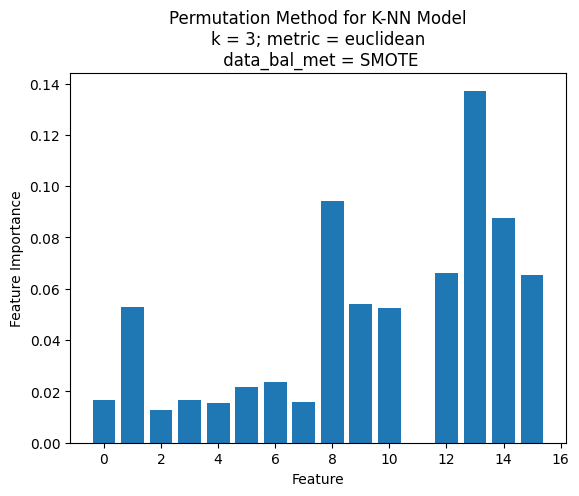

In [234]:
# Permutation for feature importance with K-NN for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Fit the model
results = permutation_importance(knn, X_ups_test, y_ups_test, scoring = 'accuracy')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for count,value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Permutation Method for K-NN Model\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

[[762  27]
 [ 29  33]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       789
           1       0.55      0.53      0.54        62

    accuracy                           0.93       851
   macro avg       0.76      0.75      0.75       851
weighted avg       0.93      0.93      0.93       851



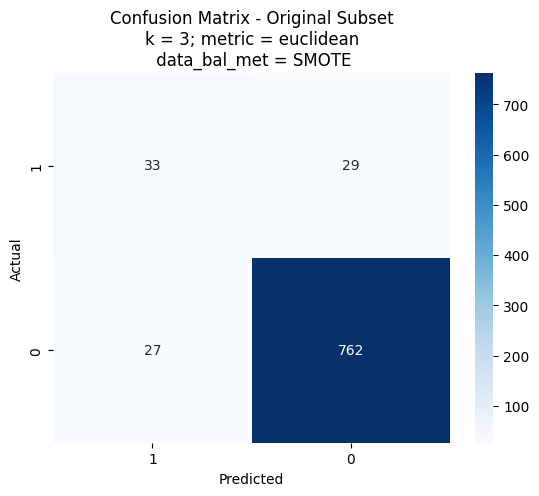

In [235]:
# Evaluate on original data
X_test = scaler.transform(X_test)
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Original Subset\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

**3.3.3 Implement Logistic Regression**

In [236]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

# Use previous data split for K-NN

# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'SMOTE'
##

In [237]:
## CONSTANTS
pen = 'l1'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_ups_train, y_ups_train)

# Display regression coefficients and R-squared value of model
print('The intercept is: %.5f' % log_reg.intercept_)
print('The regression coefficients are: ' + str(log_reg.coef_))
print('The R-squared value is: %.5f' % log_reg.score(X_ups_train, y_ups_train))

The intercept is: 2.36477
The regression coefficients are: [[-0.37217046  1.58461281 -0.03303609 -0.11618167 -0.27962029 -0.27080787
   0.30969443  0.06921876 -3.38198738 -2.73692948 -2.29553666 -0.1859278
  -2.5719525  -3.40323364 -2.36640261 -2.56887696]]
The R-squared value is: 0.92888


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       683
           1       0.97      0.89      0.93       664

    accuracy                           0.93      1347
   macro avg       0.94      0.93      0.93      1347
weighted avg       0.94      0.93      0.93      1347


Confusion Matrix:
[[664  19]
 [ 72 592]] 



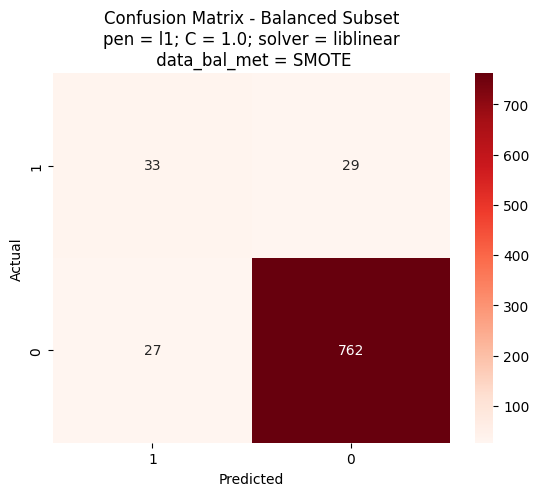

In [238]:
# Use the model to make predictions on the testing data
y_ups_pred = log_reg.predict(X_ups_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_ups_test, y_ups_pred)
class_report = classification_report(y_ups_test, y_ups_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced Subset\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       789
           1       0.37      0.24      0.29        62

    accuracy                           0.91       851
   macro avg       0.65      0.60      0.62       851
weighted avg       0.90      0.91      0.91       851


Confusion Matrix:
[[763  26]
 [ 47  15]] 



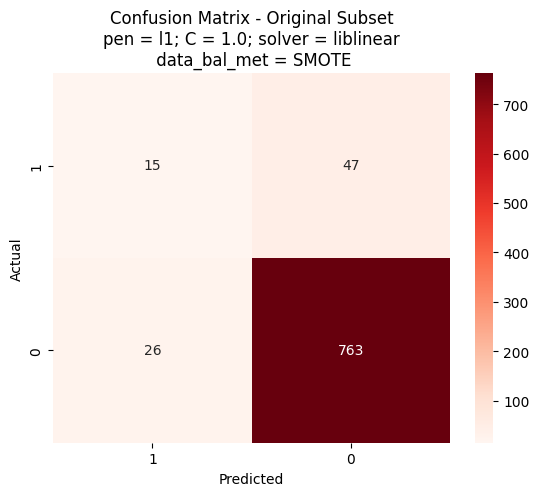

In [239]:
# Use the model to make predictions on the original testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Original Subset\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [240]:
## CONSTANTS
pen = 'l2'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_ups_train, y_ups_train)

# Display regression coefficients and R-squared value of model
print('The intercept is: %.5f' % log_reg.intercept_)
print('The regression coefficients are: ' + str(log_reg.coef_))
print('The R-squared value is: %.5f' % log_reg.score(X_ups_train, y_ups_train))

The intercept is: 1.88743
The regression coefficients are: [[-0.36939664  1.57045138 -0.03721253 -0.11755706 -0.2794988  -0.27606456
   0.30961398  0.07100113 -2.93679886 -2.42132953 -2.03893132 -0.21101829
  -2.27178896 -3.01080109 -2.09894339 -2.28462432]]
The R-squared value is: 0.92869


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       683
           1       0.97      0.89      0.93       664

    accuracy                           0.93      1347
   macro avg       0.94      0.93      0.93      1347
weighted avg       0.94      0.93      0.93      1347


Confusion Matrix:
[[664  19]
 [ 71 593]] 



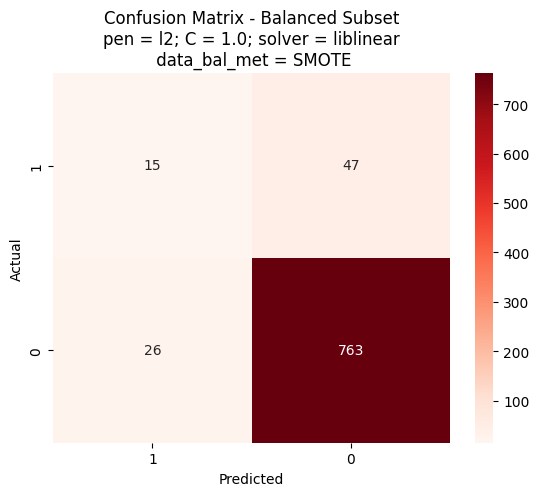

In [241]:
# Use the model to make predictions on the testing data
y_ups_pred = log_reg.predict(X_ups_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_ups_test, y_ups_pred)
class_report = classification_report(y_ups_test, y_ups_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced Subset\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       789
           1       0.35      0.23      0.27        62

    accuracy                           0.91       851
   macro avg       0.65      0.60      0.61       851
weighted avg       0.90      0.91      0.90       851


Confusion Matrix:
[[763  26]
 [ 48  14]] 



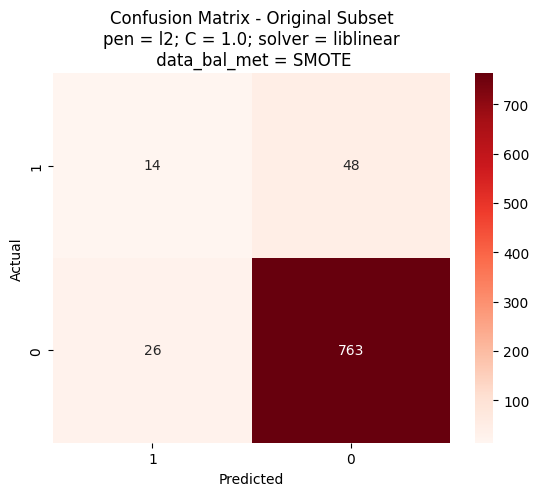

In [242]:
# Use the model to make predictions on the original testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Reds',
            fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Original Subset\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [243]:
### model summary

import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = data_ups.drop('stroke', axis=1)
y = data_ups['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

         Current function value: 0.178530
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 6732
Model:                          Logit   Df Residuals:                     6715
Method:                           MLE   Df Model:                           16
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.7424
Time:                        20:54:54   Log-Likelihood:                -1201.9
converged:                      False   LL-Null:                       -4666.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     37.8988   2409.432      0.016      0.987   -4684.501    4760.299
gender                    -0.